In [73]:
import pathlib
import importlib
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from typing import List, Tuple
from scipy import stats
import dexplot as dxp
import scipy.stats as ss
from sklearn.preprocessing import RobustScaler, StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.metrics import f1_score, roc_curve, auc, roc_auc_score
import re
from scikitplot.metrics import plot_confusion_matrix
from scikitplot.metrics import plot_roc
from sklearn.model_selection import GridSearchCV
from sklearn import tree

In [3]:
DATA_PATH = pathlib.Path('./data')
RESULTS_PATH = pathlib.Path('./results')

In [4]:
df = pd.read_csv(DATA_PATH / 'accepted_2007_to_2018Q4.csv')

In [5]:
keep_list = ['addr_state', 'annual_inc', 'application_type', 
             'dti', 'earliest_cr_line', 'emp_length', 'fico_range_high', 'fico_range_low', 
             'grade', 'home_ownership', 'initial_list_status', 
             'installment', 'int_rate', 'issue_d', 'loan_amnt', 
             'mort_acc', 'open_acc', 'pub_rec', 'pub_rec_bankruptcies', 
             'purpose', 'revol_bal', 'revol_util', 'sub_grade', 'term', 
             'title', 'total_acc', 'verification_status', 'loan_status']
keep_list.sort()
df = df[keep_list]

In [6]:
df = df[df['loan_status'].isin(['Fully Paid', 'Charged Off'])]

In [7]:
df['target'] = 1
df['target'] = (df['target'].where(df['loan_status'] == 'Charged Off', 0))
df = df.drop('loan_status', axis=1)

In [8]:
# Reminding ourselves of the data imbalance ratio
df['target'].value_counts()/df['target'].count()

0    0.800374
1    0.199626
Name: target, dtype: float64

In [9]:
num_cols = df.select_dtypes(include=['float64', 'int64']).columns

In [10]:
dates_cols = ['earliest_cr_line', 'issue_d']
for c in dates_cols:
    df[c] = pd.to_datetime(df[c], format='%b-%Y')

In [11]:
cat_cols = df.select_dtypes('object').columns

# Preprocessing

Let's start with some preprocessing now that we have some understanding of the data.

We need to start filling the missing values.

For numerical columns, for simplicity, we are going to fill missing values with the median.
For categorical columns, a simple approach would be to fill the missing values with the most common observation.

Keep in mind that these approaches are just to keep things simple. If one thinks that more time should be spent on preprocessing, they could go with fancier methods, including:
- using other ML models to come up with values for the missing 

When filling the missing values, it is important that we calculate this value using the training set only, and then use the same value for the test set
so as to avoid data leakage from the training set to the test set.

In [12]:
years = [2013, 2014, 2015, 2016]
train_years = years[0:3]
test_years = years[3:]
train_df = df[df['issue_d'].dt.year.isin(train_years)]
test_df = df[df['issue_d'].dt.year.isin(test_years)]

# Filling Missing Values

In [13]:
print("Missing Percentage")
for col in df.columns:
    missing_percentage = 100 - 100*df[col].count()/len(df)
    if missing_percentage > 0:
        print(col + " " + str())
        print(missing_percentage)
        print(df[col].dtype)

Missing Percentage
dti 
0.027800283949417803
float64
emp_length 
5.835903992388367
object
mort_acc 
3.5145059503014124
float64
pub_rec_bankruptcies 
0.05180962008756751
float64
revol_util 
0.0637027896915896
float64
title 
1.23830195270979
object


A simple approach for numerical features: Fill with the median

For categorical features we can fill with the most frequent values

In [14]:
def preprocessing(df, num_cols, cat_cols):

    for col in num_cols:
        median = df[col].median()
        df[col] = df[col].fillna(median)

    for col in cat_cols:
        most_common = df[col].mode()[0]
        df[col] = df[col].fillna(most_common)
    
    return df

# Remark: the training and test medians might not be exactly the same, so the values filled would be different
# This also applies to the most common observation, which may be different in the test set

In [15]:
LABEL_ENCODERS = {}
SCALER = RobustScaler()

In [266]:
def feature_engineering(df, num_cols, cat_cols, log_cols=None, is_train=True):
    ''' This function will be used to take the log of our features, scale our features, encodings, etc.'''

    # taking the log of features in log_cols
    # a problem is that at least one feature has neg values, so we are going to drop those rows
    df = df[df['dti'] > -1]

    if log_cols:
        for col in log_cols:
            df[col] = np.log1p(df[col])
    
    # not every model requires feature scaling but some do
    # let's scale the numerical features with robustscaler
    scaler = StandardScaler()
    if is_train:
        df[num_cols] = SCALER.fit_transform(df[num_cols])
    else:
        df[num_cols] = SCALER.transform(df[num_cols])


    # some feature engineering specific to a variable
    # df['emp_length'] = df['emp_length'].apply(lambda x: '0' if x is '< 1 year' else x)
    df['emp_length'] = df['emp_length'].str.replace('[^0-9]+', '')

    cat_cols = list(cat_cols)
    cat_cols.remove('emp_length')

    for col in cat_cols:
        encoder = LabelEncoder()
        print(col)
        if is_train:
            df[col] = encoder.fit_transform(df[col])
            LABEL_ENCODERS[col] = encoder
        else:
            df[col] =LABEL_ENCODERS[col].transform(df[col])

    return df

In [17]:
log_cols = [
    'annual_inc',
    'dti',
    'installment',
    'int_rate',
    'loan_amnt',
    'open_acc',
    'revol_bal',
    'revol_util',
    'total_acc'
]

In [18]:
train_df = preprocessing(train_df, num_cols, cat_cols)

In [19]:
train_df2 = feature_engineering(train_df, num_cols, cat_cols, log_cols, is_train=True)

addr_state
application_type
grade
home_ownership
initial_list_status
purpose
sub_grade
term
title
verification_status


In [20]:
test_df = preprocessing(test_df, num_cols, cat_cols)

In [21]:
test_df2 = feature_engineering(test_df, num_cols, cat_cols, log_cols, is_train=False)

addr_state
application_type
grade
home_ownership
initial_list_status
purpose
sub_grade
term
title
verification_status


In [22]:
train_df2.columns

Index(['addr_state', 'annual_inc', 'application_type', 'dti',
       'earliest_cr_line', 'emp_length', 'fico_range_high', 'fico_range_low',
       'grade', 'home_ownership', 'initial_list_status', 'installment',
       'int_rate', 'issue_d', 'loan_amnt', 'mort_acc', 'open_acc', 'pub_rec',
       'pub_rec_bankruptcies', 'purpose', 'revol_bal', 'revol_util',
       'sub_grade', 'term', 'title', 'total_acc', 'verification_status',
       'target'],
      dtype='object')

In [23]:
cols = ['addr_state', 'annual_inc', 'application_type', 'dti',
       'emp_length', 'fico_range_high', 'grade', 'home_ownership', 'initial_list_status',
       'installment', 'int_rate', 'mort_acc',
       'open_acc', 'pub_rec', 'pub_rec_bankruptcies', 'purpose', 'revol_bal',
       'revol_util', 'sub_grade', 'term', 'title', 'total_acc',
       'verification_status']

In [24]:
X_train = train_df2[cols]
y_train = train_df2['target']

In [25]:
X_test = test_df2[cols]
y_test = test_df2['target']

# Training a decision tree model

In [26]:
from sklearn.tree import DecisionTreeClassifier

In [27]:
DecisionTreeClassifier?

Init signature:
DecisionTreeClassifier(
    criterion='gini',
    splitter='best',
    max_depth=None,
    min_samples_split=2,
    min_samples_leaf=1,
    min_weight_fraction_leaf=0.0,
    max_features=None,
    random_state=None,
    max_leaf_nodes=None,
    min_impurity_decrease=0.0,
    min_impurity_split=None,
    class_weight=None,
    presort=False,
)
Docstring:     
A decision tree classifier.

Read more in the :ref:`User Guide <tree>`.

Parameters
----------
criterion : string, optional (default="gini")
    The function to measure the quality of a split. Supported criteria are
    "gini" for the Gini impurity and "entropy" for the information gain.

splitter : string, optional (default="best")
    The strategy used to choose the split at each node. Supported
    strategies are "best" to choose the best split and "random" to choose
    the best random split.

max_depth : int or None, optional (default=None)
    The maximum depth of the tree. If None, then nodes are expanded unt

In [28]:
dt = DecisionTreeClassifier()

In [29]:
dt.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')

In [30]:
y_train_pred = dt.predict(X_train)

<AxesSubplot:title={'center':'Confusion Matrix'}, xlabel='Predicted label', ylabel='True label'>

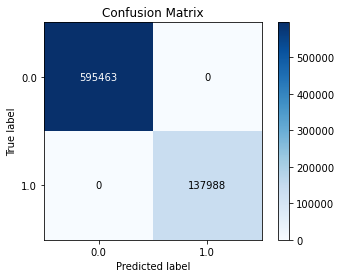

In [31]:
plot_confusion_matrix(y_train, y_train_pred, normalize=False)

In [32]:
# Perfect Matrix? Let's look at the test set...

y_test_pred = dt.predict(X_test)

<AxesSubplot:title={'center':'Confusion Matrix'}, xlabel='Predicted label', ylabel='True label'>

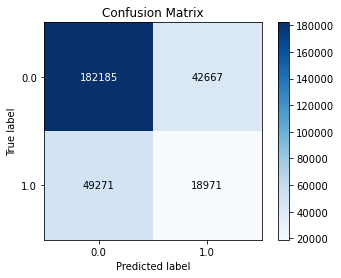

In [33]:
plot_confusion_matrix(y_test, y_test_pred, normalize=False)

<AxesSubplot:title={'center':'Normalized Confusion Matrix'}, xlabel='Predicted label', ylabel='True label'>

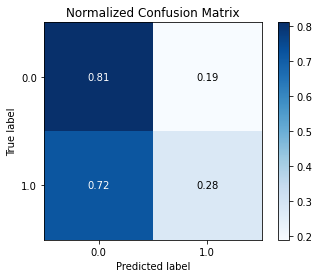

In [34]:
plot_confusion_matrix(y_test, y_test_pred, normalize=True)

In [35]:
print(classification_report(y_train, y_train_pred))

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00    595463
         1.0       1.00      1.00      1.00    137988

    accuracy                           1.00    733451
   macro avg       1.00      1.00      1.00    733451
weighted avg       1.00      1.00      1.00    733451



In [36]:
print(classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

         0.0       0.79      0.81      0.80    224852
         1.0       0.31      0.28      0.29     68242

    accuracy                           0.69    293094
   macro avg       0.55      0.54      0.55    293094
weighted avg       0.68      0.69      0.68    293094



In [37]:
dt.tree_.max_depth

58

In [38]:
CM = confusion_matrix(y_test, y_test_pred)

In [39]:
CM

array([[182185,  42667],
       [ 49271,  18971]])

In [40]:
TP = CM[1][1]
FP = CM[0][1]

FN = CM[1][0]
TN = CM[0][0]

P = TP + FN
N = TN + FP

In [41]:
TPR = TP/P

In [42]:
FPR = FP/N

In [43]:
TPR

0.27799595556988366

In [44]:
FPR

0.18975592834397736

In [45]:
TPR/FPR

1.46501855302223

In [46]:
# Compute ROC curve and ROC area for each class
fpr, tpr, _ = roc_curve(y_test, y_test_pred)
roc_auc = auc(fpr, tpr)

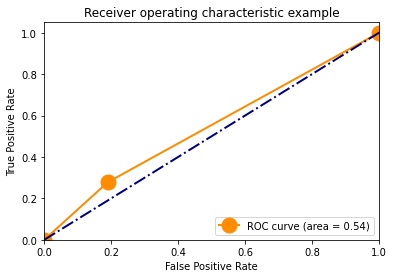

In [47]:
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc, marker='o', markersize='15')
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='-.')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

For a model that picks the labels randomly, we expect a model that will pick 'positive' regardless of whether a datapoint is actually positive or not.
Thus, the baseline is TPR = FPR.

The current model is doing *worse* than the baseline.



Problems:

* Data imbalance: the model does better for class 0
* Overfitting: clearly we can't let the tree grow arbitrarily large
* We don't have a clear evaluation metric yet (though confusion matrices, recall and precision are all good indicators)

Dealing with the class imbalance. Here are some strategies:
* Assigning weights to the labels: penalize the model more for getting wrong answers for class 1
* Oversampling: synthetically create more examples of the rare class
* Undersampling: reduce the number of examples coming from the most common class

The first strategy can be implemented with the decision tree model by setting one of the parameters.
For the sake of time, this is the strategy we will pursue here.

With regards to the overfitting problem, we need a way to choose the hyperparameters of the model.

In [48]:
param_grid = {
    'max_depth': [5, 10, 15, 20],
    'min_samples_split': [2, 20],
    'min_samples_leaf': [1, 10, 100, 1000, 2000, 10000],
    'random_state': [42],
    'class_weight': [None, 'balanced']
    }

In [49]:
clf = GridSearchCV(estimator=DecisionTreeClassifier(),
             param_grid=param_grid,
             scoring='f1',
             n_jobs=-1,
             verbose=2)

In [50]:
clf.fit(X_train, y_train)

Fitting 3 folds for each of 96 candidates, totalling 288 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    7.8s
[Parallel(n_jobs=-1)]: Done 122 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 288 out of 288 | elapsed:  4.0min finished


GridSearchCV(cv='warn', error_score='raise-deprecating',
             estimator=DecisionTreeClassifier(class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features=None,
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              presort=False, random_state=None,
                                              splitter='best'),
             iid='warn', n_jobs=-1,
             param_grid={'class_weight': [None, 'balanced'],
                         'max_depth': [5, 10, 15, 20],
                 

In [51]:
clf.best_params_

{'class_weight': 'balanced',
 'max_depth': 10,
 'min_samples_leaf': 2000,
 'min_samples_split': 2,
 'random_state': 42}

In [52]:
# Perfect Matrix? Let's look at the test set...

y_test_pred2 = clf.predict(X_test)

<AxesSubplot:title={'center':'Normalized Confusion Matrix'}, xlabel='Predicted label', ylabel='True label'>

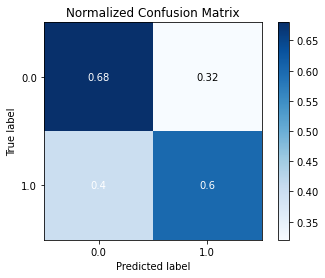

In [53]:
plot_confusion_matrix(y_test, y_test_pred2, normalize=True)

In [54]:
print(classification_report(y_test, y_test_pred2))

              precision    recall  f1-score   support

         0.0       0.85      0.68      0.75    224852
         1.0       0.36      0.60      0.45     68242

    accuracy                           0.66    293094
   macro avg       0.61      0.64      0.60    293094
weighted avg       0.74      0.66      0.68    293094



In [55]:
CM2 = confusion_matrix(y_test, y_test_pred2)

In [56]:
TPR2 = CM2[1][1]/(CM2[1][0] + CM2[1][1] )
FPR2 = CM2[0][1]/(CM2[0][0] + CM2[0][1] )

In [57]:
TPR2/FPR2

1.882016682699884

In [58]:
# Compute ROC curve and ROC area for each class
fpr2, tpr2, _ = roc_curve(y_test, y_test_pred2)
roc_auc2 = auc(fpr2, tpr2)

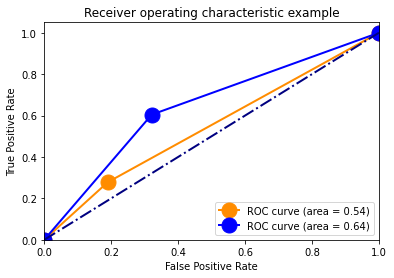

In [59]:
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc, marker='o', markersize='15')
plt.plot(fpr2, tpr2, color='blue',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc2, marker='o', markersize='15')
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='-.')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

In [60]:
TPR/FPR

1.46501855302223

In [61]:
TPR2/FPR2

1.882016682699884

# Feature importance

In [62]:
feature_importance = pd.DataFrame(zip(X_train.columns, clf.best_estimator_.feature_importances_), columns=['feature', 'importance'])

In [63]:
feature_importance = feature_importance.sort_values(by=['importance'], ascending=False)
feature_importance.index = feature_importance['feature']

In [64]:
feature_importance.head()

,feature,importance
feature,,
sub_grade,sub_grade,0.743009
term,term,0.124962
dti,dti,0.033300
mort_acc,mort_acc,0.018974
home_ownership,home_ownership,0.017372


<AxesSubplot:xlabel='feature'>

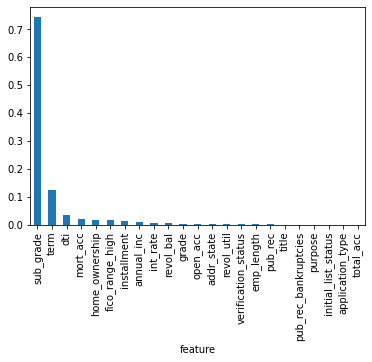

In [65]:
feature_importance['importance'].plot(kind='bar')

At this point we may want to consider training the model only with the most important features to see what happens.

In [346]:
important_cols = ['term', 'dti', 'mort_acc', 'home_ownership', 'int_rate']

In [347]:
simpler_dt = DecisionTreeClassifier(
 class_weight='balanced',
 max_depth=10,
 min_samples_leaf=1000,
 min_samples_split=2,
 min_impurity_decrease=0.005,
 random_state=42
)

In [348]:
simpler_dt.fit(X_train[important_cols], y_train)

DecisionTreeClassifier(class_weight='balanced', criterion='gini', max_depth=10,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.005, min_impurity_split=None,
                       min_samples_leaf=1000, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=42, splitter='best')

In [349]:
y_train_pred3 = simpler_dt.predict(X_train[important_cols])

print(classification_report(y_train, y_train_pred3))

              precision    recall  f1-score   support

         0.0       0.89      0.58      0.70    595463
         1.0       0.28      0.70      0.40    137988

    accuracy                           0.60    733451
   macro avg       0.58      0.64      0.55    733451
weighted avg       0.78      0.60      0.64    733451



In [350]:
y_test_pred3 = simpler_dt.predict(X_test[important_cols])

In [351]:
print(classification_report(y_test, y_test_pred2))

              precision    recall  f1-score   support

         0.0       0.85      0.68      0.75    224852
         1.0       0.36      0.60      0.45     68242

    accuracy                           0.66    293094
   macro avg       0.61      0.64      0.60    293094
weighted avg       0.74      0.66      0.68    293094



In [352]:
print(classification_report(y_test, y_test_pred3))

              precision    recall  f1-score   support

         0.0       0.85      0.64      0.73    224852
         1.0       0.35      0.64      0.45     68242

    accuracy                           0.64    293094
   macro avg       0.60      0.64      0.59    293094
weighted avg       0.73      0.64      0.66    293094



In [353]:
fpr3, tpr3, _ = roc_curve(y_test, y_test_pred3)
roc_auc3 = auc(fpr3, tpr3)

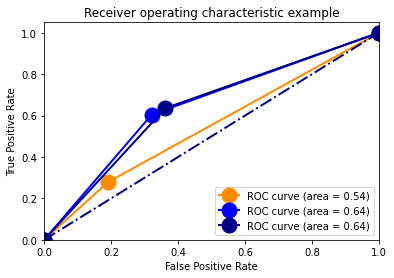

In [354]:
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc, marker='o', markersize='15')
plt.plot(fpr2, tpr2, color='blue',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc2, marker='o', markersize='15')
plt.plot(fpr3, tpr3, color='darkblue',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc3, marker='o', markersize='15')
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='-.')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

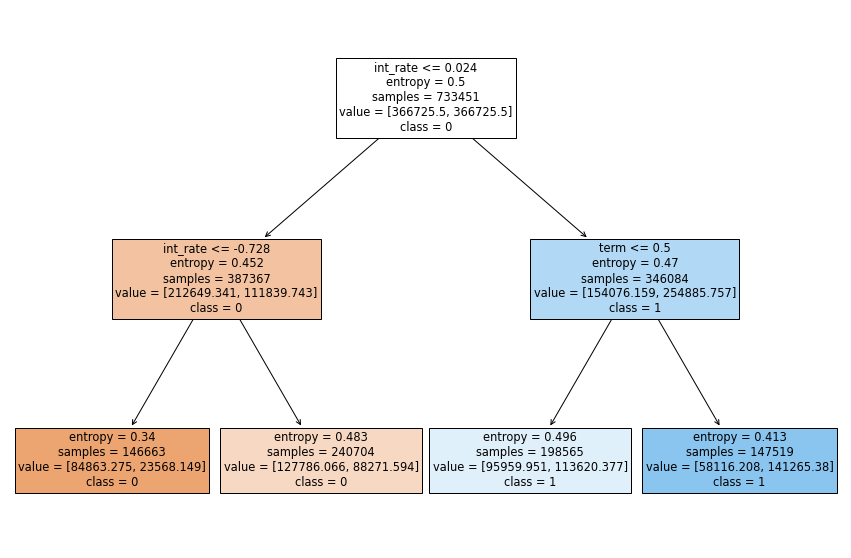

In [355]:
fig = plt.figure(figsize=(15,10))
_ = tree.plot_tree(
    simpler_dt,
    feature_names=important_cols,
    class_names=['0', '1'],
    filled=True
)

AttributeError: 'DecisionTreeClassifier' object has no attribute 'depth_'

# Does log matter?

In [267]:
train_df3 = feature_engineering(train_df, num_cols, cat_cols, log_cols=None, is_train=True)

addr_state
application_type
grade
home_ownership
initial_list_status
purpose
sub_grade
term
title
verification_status


In [281]:
test_df3 = feature_engineering(test_df, num_cols, cat_cols, log_cols=None, is_train=False)

addr_state
application_type
grade
home_ownership
initial_list_status
purpose
sub_grade
term
title
verification_status


In [282]:
X_train_nolog = train_df3[cols]
y_train_nolog = train_df3['target']
X_test_nolog = test_df3[cols]
y_test_nolog = test_df3['target']

In [283]:
simpler_dt_nolog = DecisionTreeClassifier(
 class_weight='balanced',
 max_depth=2,
 min_samples_leaf=1000,
 min_samples_split=2,
 min_impurity_decrease=0.00,
 random_state=42
)

In [284]:
simpler_dt_nolog.fit(X_train_nolog[cols], y_train_nolog)

DecisionTreeClassifier(class_weight='balanced', criterion='gini', max_depth=2,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1000, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=42, splitter='best')

In [285]:
y_test_pred_nolog = simpler_dt_nolog.predict(X_test_nolog[cols])

In [286]:
print(classification_report(y_test, y_test_pred_nolog))

              precision    recall  f1-score   support

         0.0       0.86      0.61      0.71    224852
         1.0       0.34      0.67      0.45     68242

    accuracy                           0.62    293094
   macro avg       0.60      0.64      0.58    293094
weighted avg       0.74      0.62      0.65    293094



In [289]:
fpr_nolog, tpr_nolog, _ = roc_curve(y_test, y_test_pred_nolog)
roc_auc_nolog = auc(fpr_nolog, tpr_nolog)

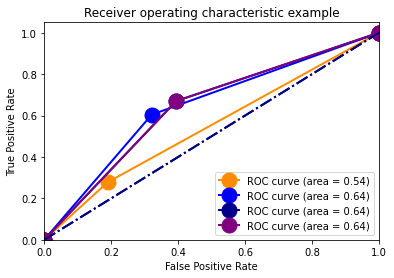

In [290]:
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc, marker='o', markersize='15')
plt.plot(fpr2, tpr2, color='blue',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc2, marker='o', markersize='15')
plt.plot(fpr3, tpr3, color='darkblue',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc3, marker='o', markersize='15')
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='-.')
plt.plot(fpr_nolog, tpr_nolog, color='purple',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc_nolog, marker='o', markersize='15')
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='-.')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()